In [1]:
from pandas import DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from itertools import product
from tqdm.notebook import tqdm
from datetime import date, timedelta

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import re
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

2023-08-22 22:46:28.700998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ameya/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
stock_name = "GOOG"
end_date = datetime.now()

# Format the current date as "year-month-date"
# formatted_date = cend_date.strftime('%Y-%m-%d')
start_date = "2015-01-01"
end_date  = end_date.strftime('%Y-%m-%d')
curr_stock = stock_name + "L"

In [3]:
my_df = yf.download(curr_stock, start=start_date, end=end_date)
my_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.629999,26.790001,26.393999,26.477501,26.477501,26480000
2015-01-05,26.357500,26.399500,25.887501,25.973000,25.973000,41182000
2015-01-06,26.025000,26.060499,25.277500,25.332001,25.332001,54456000
2015-01-07,25.547501,25.574499,25.182501,25.257500,25.257500,46918000
2015-01-08,25.075500,25.375000,24.750999,25.345501,25.345501,73054000
...,...,...,...,...,...,...
2023-08-15,131.100006,131.419998,129.279999,129.779999,129.779999,19770700
2023-08-16,128.699997,130.279999,127.870003,128.699997,128.699997,25216100
2023-08-17,129.800003,131.990005,129.289993,129.919998,129.919998,33446300


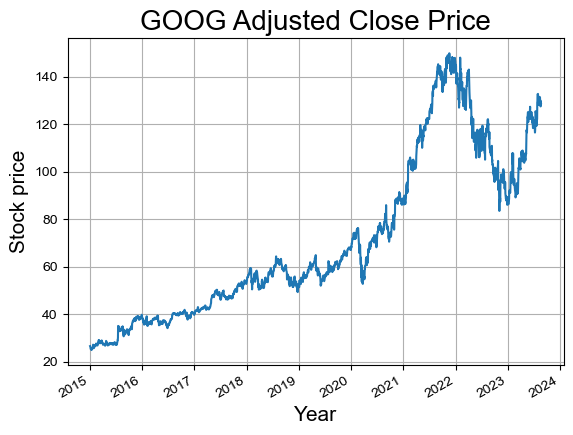

In [4]:
# Plot Adjusted Close price

my_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(15, 9)})
plt.title( stock_name+' Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

## Moving Average

In [5]:
df_adj = my_df[['Adj Close']]
df_adj

,Adj Close
Date,
2015-01-02,26.477501
2015-01-05,25.973000
2015-01-06,25.332001
2015-01-07,25.257500
2015-01-08,25.345501
...,...
2023-08-15,129.779999
2023-08-16,128.699997
2023-08-17,129.919998


In [6]:
split = int(0.8*len(df_adj))
train, test = df_adj[:split], df_adj[split:]

In [7]:
df_adj.shape, train.shape, test.shape

((2173, 1), (1738, 1), (435, 1))

In [8]:
preds = []
for i in range(0,435):
    a = train[len(train)-435+i:].sum() + sum(preds)
    b = a/435
    preds.append(b)
    
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

21.640408614857847

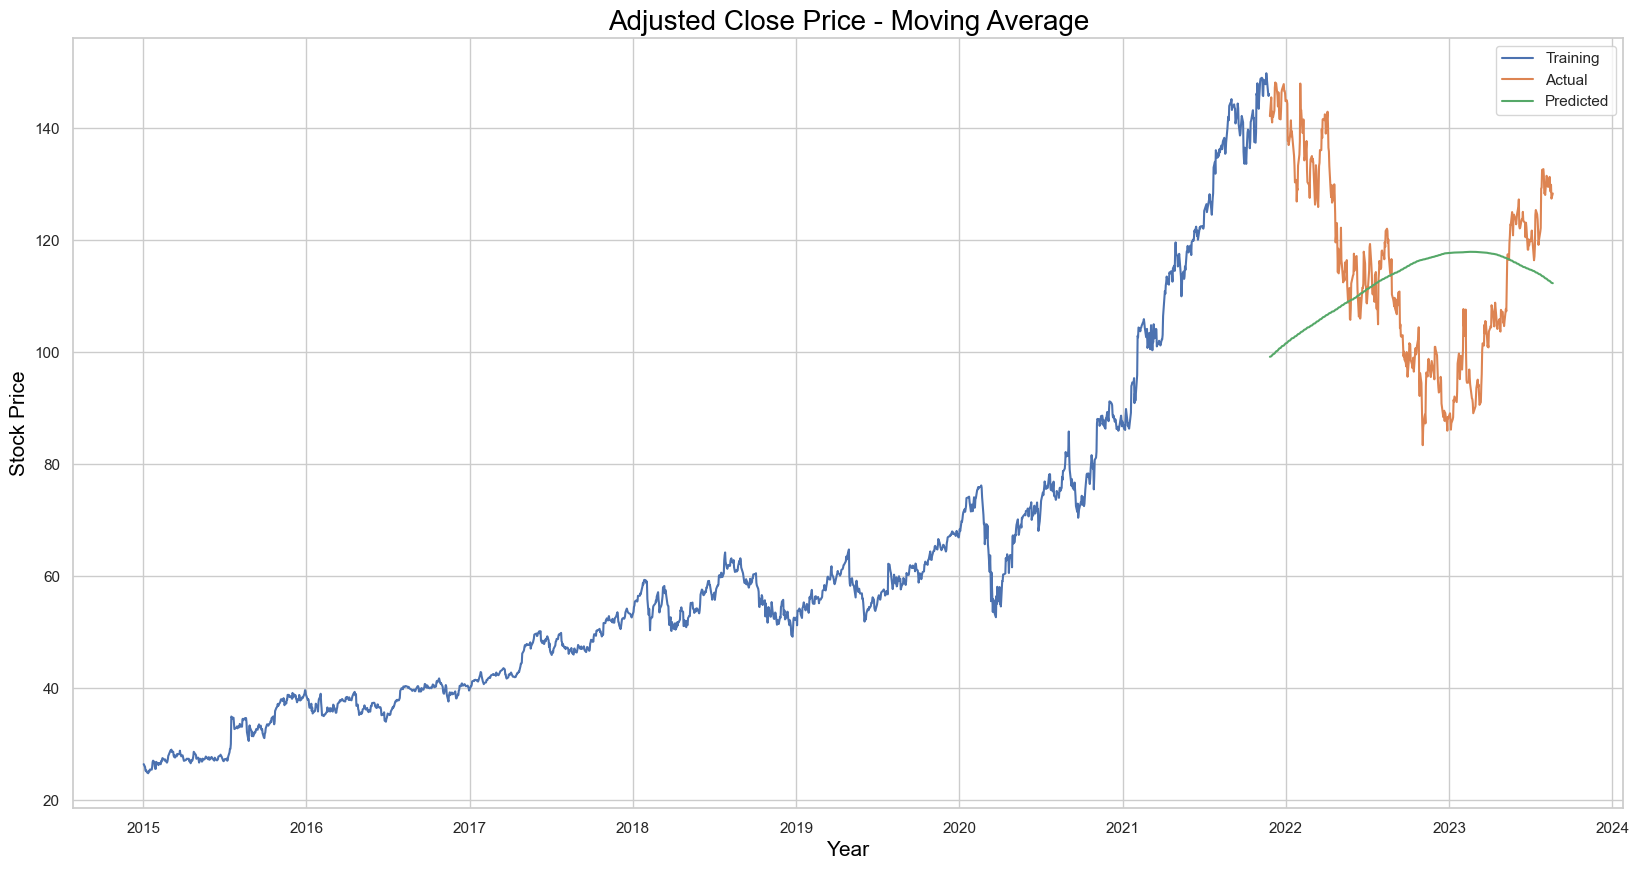

In [9]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds
plt.plot(train, label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Close Price - Moving Average", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## Models

In [10]:
df_adj['Date'] = pd.to_datetime(df_adj.index, format='%Y-%m-%d')
df_adj.index = df_adj['Date']

df_adj = pd.DataFrame(index=range(0,len(my_df)),columns=['Date', 'Adj Close'])

for i in range(0,len(my_df)):
     df_adj['Date'][i] = my_df.index[i]
     df_adj['Adj Close'][i] = my_df['Adj Close'][i]

In [11]:
import pandas as pd
import numpy as np
import re

def add_datepart(df, fldname, drop=True, time=False):
    """
    Helper function that adds columns relevant to a date.
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr += ['Hour', 'Minute', 'Second']
    for n in attr:
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop:
        df.drop(fldname, axis=1, inplace=True)


In [12]:
add_datepart(df_adj, 'Date')
df_adj.drop('Elapsed', axis=1, inplace=True)  # Elapsed is the time stamp

In [13]:
df_adj.columns
df_adj['mon_fri'] = 0
for i in range(0,len(df_adj)):
    if (df_adj['Dayofweek'][i] == 0 or df_adj['Dayofweek'][i] == 4):
        df_adj['mon_fri'][i] = 1
    else:
        df_adj['mon_fri'][i] = 0

In [14]:
split = int(0.8*len(df_adj))
train, test = df_adj[:split], df_adj[split:]

X_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
X_test = test.drop('Adj Close', axis=1)
y_test = test['Adj Close']

## Linear Regression

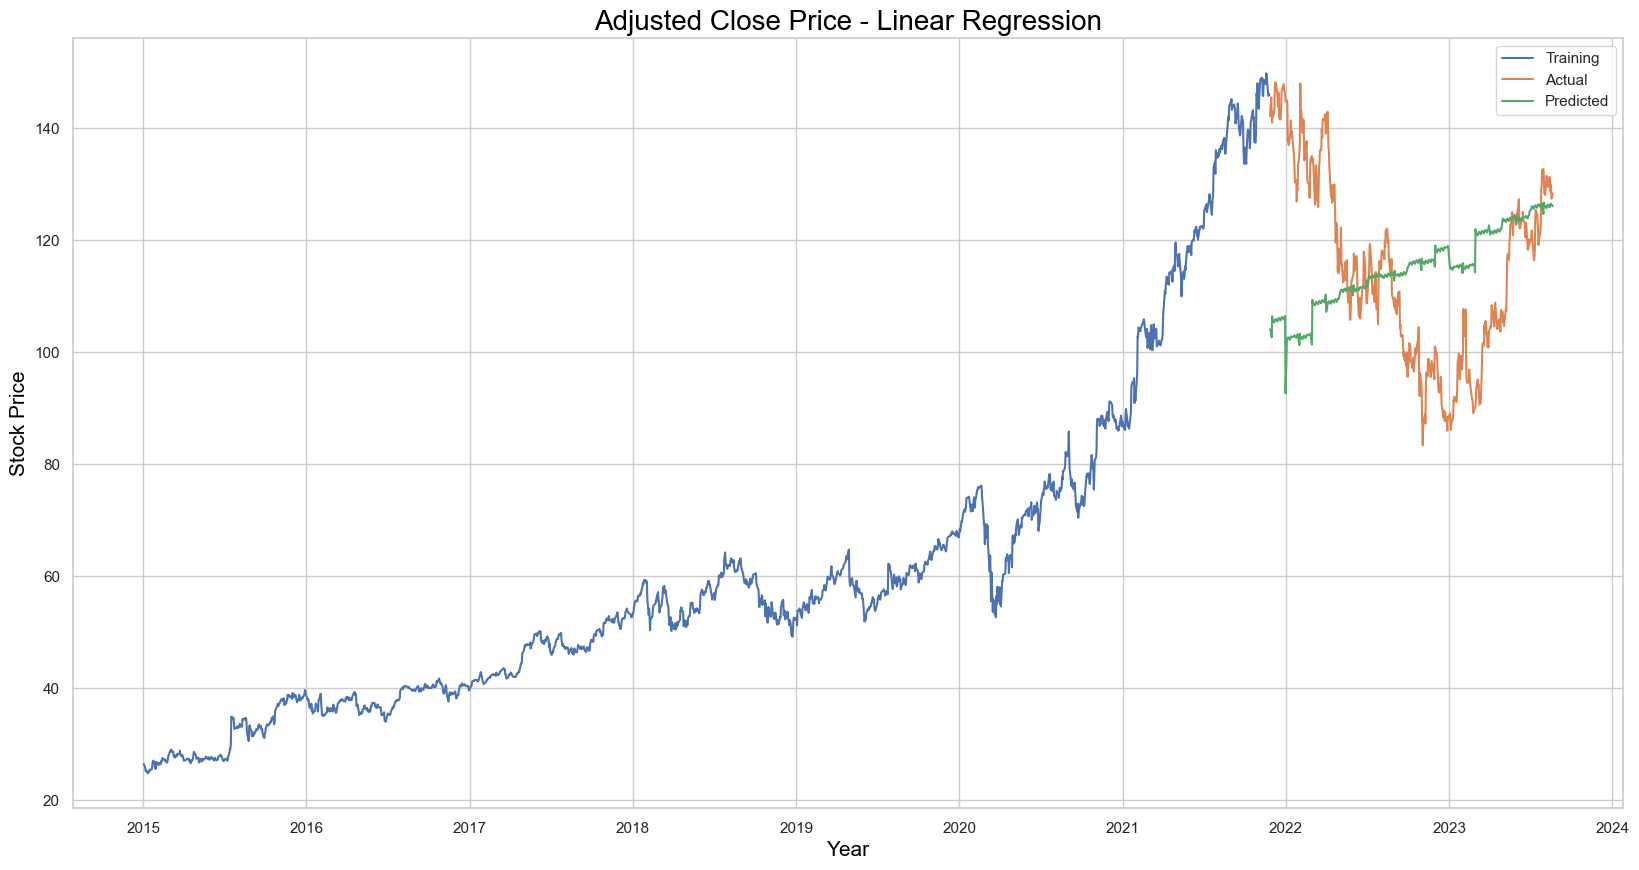

In [15]:
model = LinearRegression()
model.fit(X_train,y_train)

rmse = np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
preds = model.predict(X_test)

# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = my_df[split:].index
train.index = my_df[:split].index

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Close Price - Linear Regression", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();
     

 ## k-Nearest Neighbours

In [19]:
# Normalisation - rescaling of the data so that all values are within the range of 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_test_scaled = scaler.transform(X_test) 
X_test = pd.DataFrame(X_test_scaled)

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
preds = model.predict(X_test)

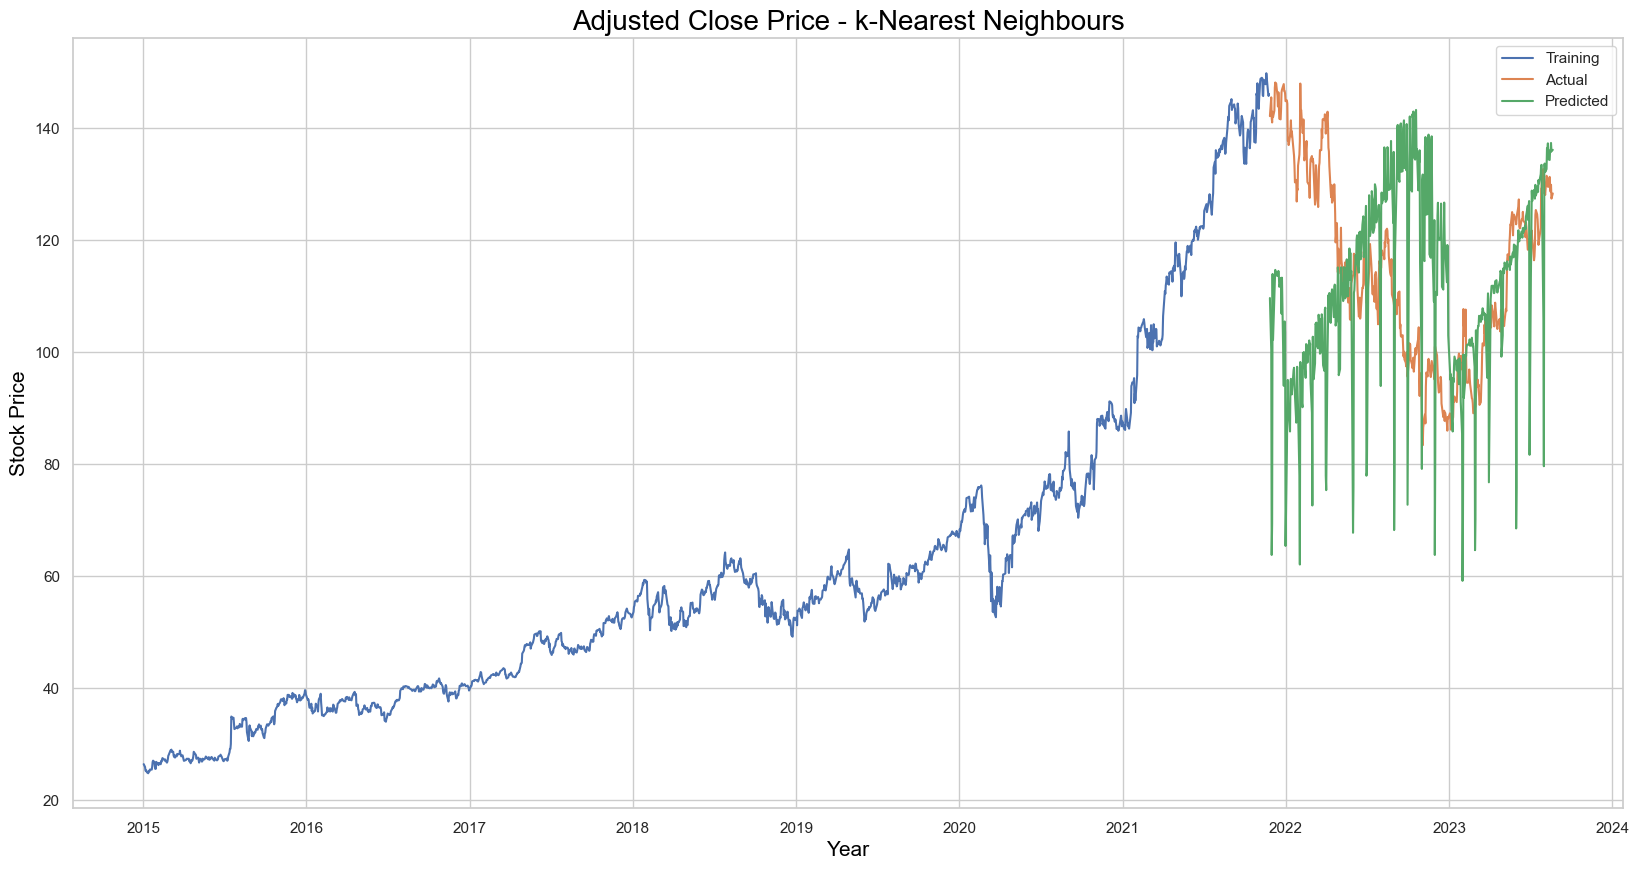

In [21]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Adjusted Close Price - k-Nearest Neighbours", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## Auto ARIMA

In [22]:
df_adj = my_df[['Adj Close']]
df_adj 

,Adj Close
Date,
2015-01-02,26.477501
2015-01-05,25.973000
2015-01-06,25.332001
2015-01-07,25.257500
2015-01-08,25.345501
...,...
2023-08-15,129.779999
2023-08-16,128.699997
2023-08-17,129.919998


In [24]:
split = int(0.8*len(df_adj))

train, test = df_adj[:split],df_adj[split:]

# Create model to find best parameters
model = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
# Train model
model.fit(train)
# Make predictions on test set
forecast = model.predict(n_periods=504)
# Create DataFrame for Predictions
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
     

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6313.812, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5849.026, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=6314.195, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=5639.352, Time=0.66 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5650.609, Time=0.53 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=5638.885, Time=0.71 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=5846.115, Time=0.37 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.59 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.69 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=5639.467, Time=0.86 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=5640.3

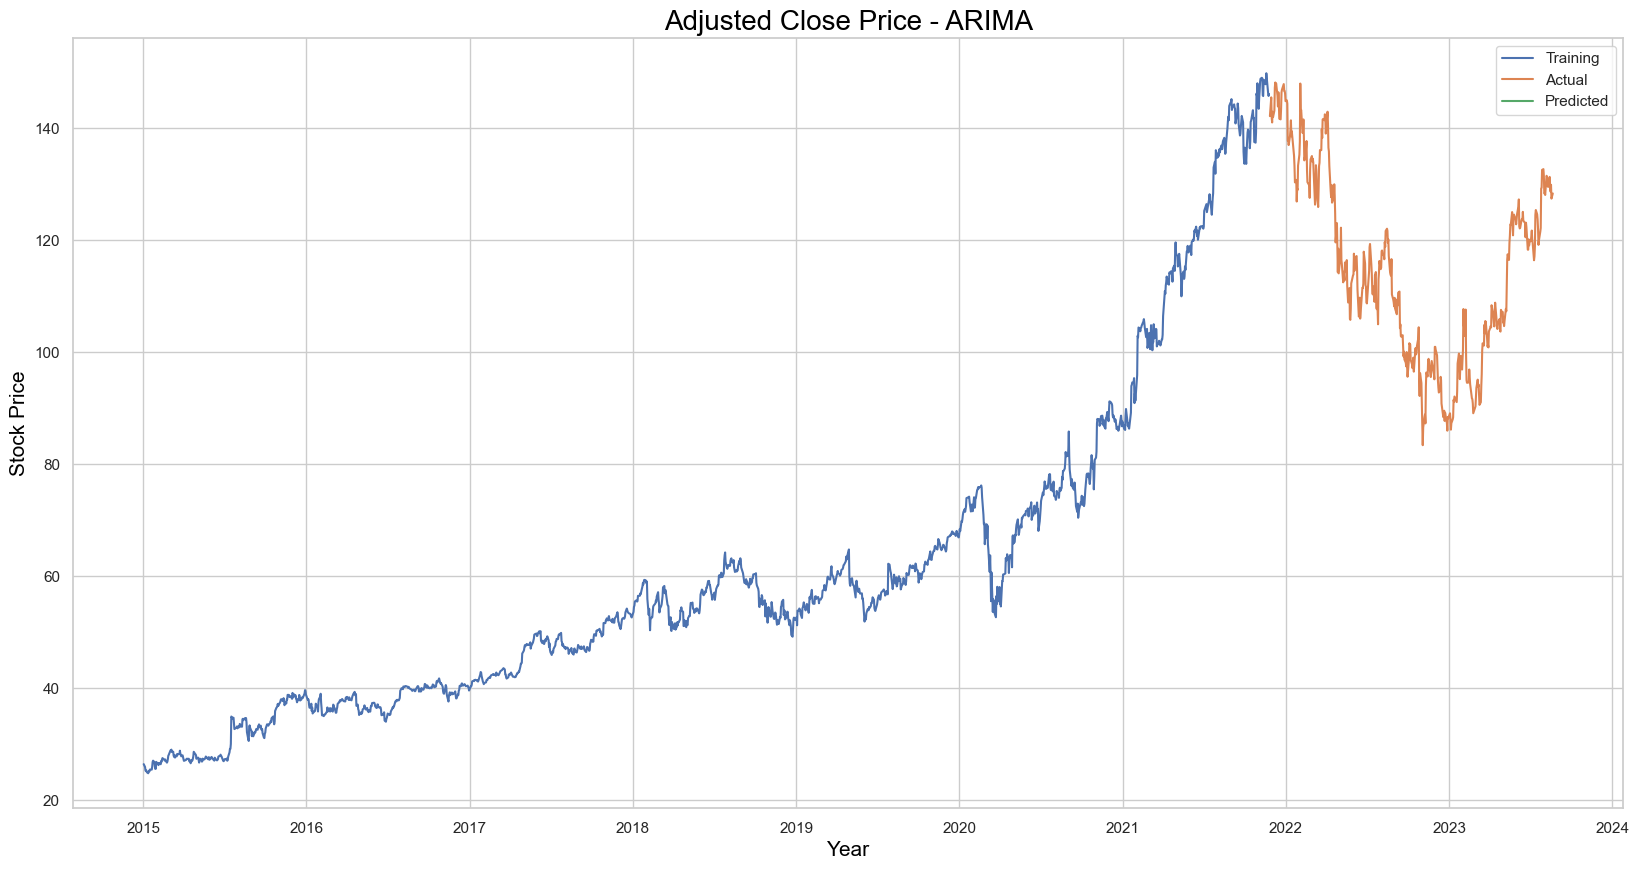

In [27]:
# Plot predicted vs actual values
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(forecast['Prediction'], label='Predicted')
plt.title("Adjusted Close Price - ARIMA", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

## Long Short Term Memory (LSTM)

In [29]:
df_adj = my_df[['Adj Close']]
df_adj 

,Adj Close
Date,
2015-01-02,26.477501
2015-01-05,25.973000
2015-01-06,25.332001
2015-01-07,25.257500
2015-01-08,25.345501
...,...
2023-08-15,129.779999
2023-08-16,128.699997
2023-08-17,129.919998


In [31]:
df_adj_arr = df_adj.values
split = int(0.8*len(df_adj_arr))

train, test = df_adj_arr[:split], df_adj_arr[split:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_adj_arr)

In [34]:
X_train, y_train = [], []
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 504 values, using past 60 from the train data
inputs = df_adj_arr [len(df_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

1678/1678 - 20s - loss: 0.0012 - 20s/epoch - 12ms/step


In [35]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

# Convert data to numpy array
X_test = np.array(X_test)

# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
adj_closing_price = model.predict(X_test)
adj_closing_price = scaler.inverse_transform(adj_closing_price)

14/14 [==============================] - 1s 9ms/step


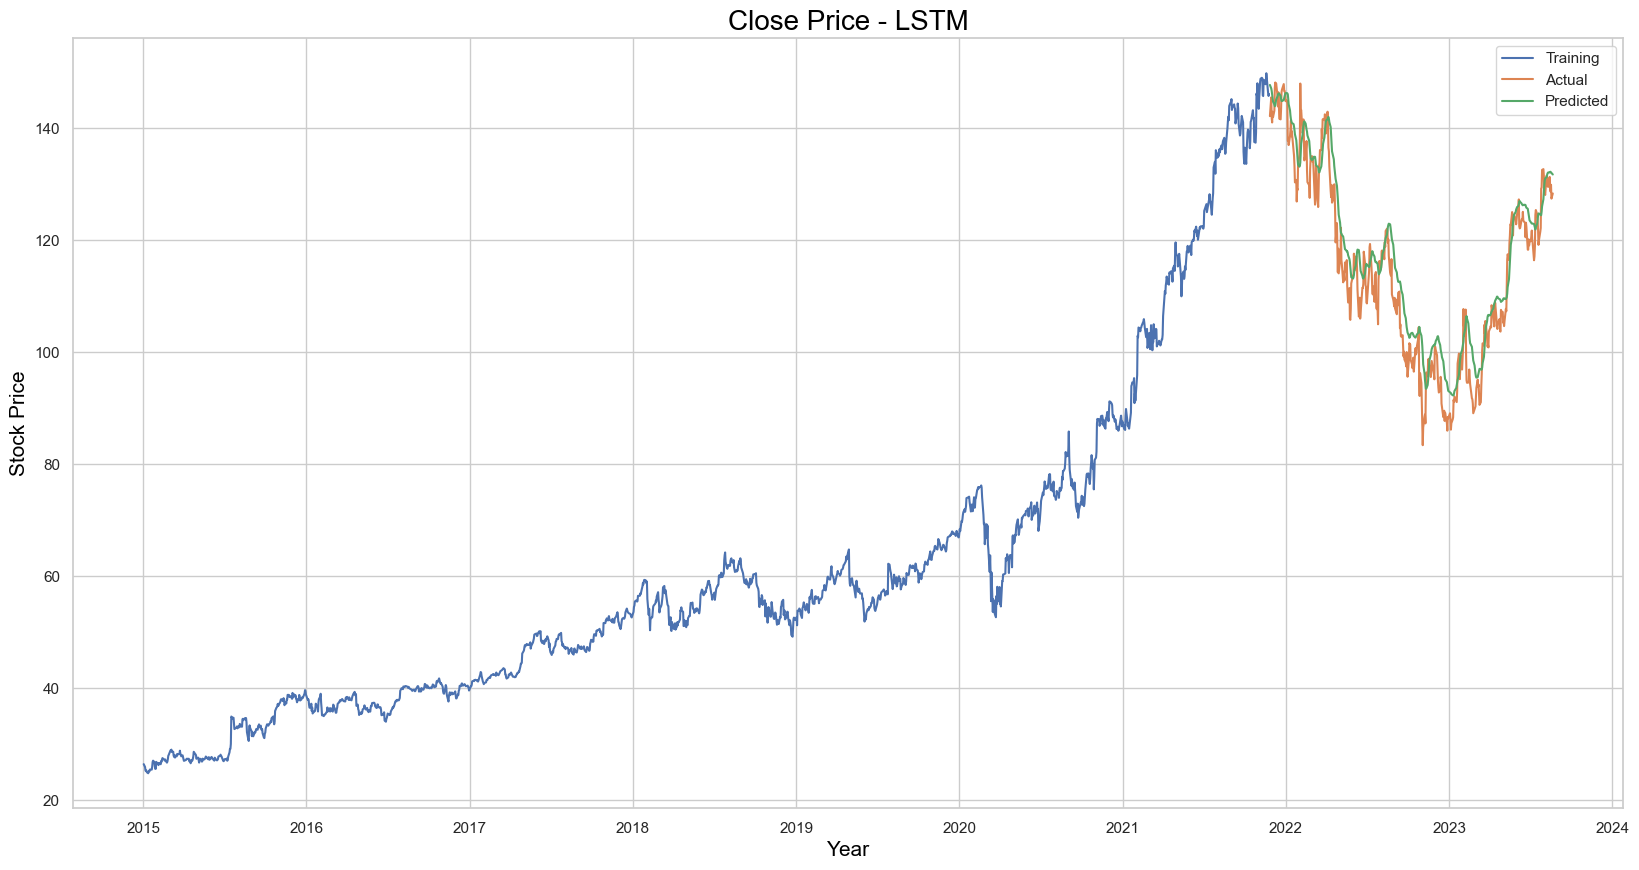

In [37]:
# Plot predicted vs actual values
train = df_adj[:split]
test = df_adj[split:]
test['Predictions'] = adj_closing_price

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();